In [ ]:
#Setting up and Imports


from google.colab import drive
drive.flush_and_unmount()         # unmount if already mounted
!rm -rf /content/drive            # clear old directory handle
drive.mount('/content/drive', force_remount=True)

# (Optional) install if needed
!pip -q install imbalanced-learn==0.12.3

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.9 MB/s eta 0:00:00


In [ ]:

!pip -q install imbalanced-learn pillow imagehash scikit-image

# Core
import os, random, numpy as np
import matplotlib.pyplot as plt

# Images / features
import cv2 as cv
from PIL import Image
import imagehash
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# (Optional) GLCM features if you want to mimic the paper's texture pipeline
from skimage.feature import graycomatrix, graycoprops

# Splits & metrics
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             auc, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score)
from sklearn.base import BaseEstimator, ClassifierMixin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.7 MB/s eta 0:00:00


In [ ]:

melasma_dir = '/content/drive/MyDrive/original_melasma'
others_dir  = '/content/drive/MyDrive/og_nonmelasma'

from pathlib import Path
def collect_images(root):
    exts = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff','.gif','.jfif','.pjpeg','.pjp', '.JPG'}
    root = Path(root)
    if not root.exists():
        print(f"[!] Missing folder: {root}")
        return []
    return [str(p) for p in root.rglob('*') if p.suffix.lower() in exts]

melasma_paths = sorted(collect_images(melasma_dir))
others_paths  = sorted(collect_images(others_dir))

X_paths = melasma_paths + others_paths
y       = np.array([1]*len(melasma_paths) + [0]*len(others_paths))  # 1=Melasma, 0=Others

print(f"#Melasma={len(melasma_paths)}  #Others={len(others_paths)}  #Total={len(X_paths)}")


#Melasma=30  #Others=33  #Total=63


In [ ]:
def phash_groups(paths, hash_size=16, distance_thresh=4):
    N = len(paths)
    phashes = []
    for p in paths:
        try:
            with Image.open(p) as im:
                phashes.append(imagehash.phash(im.convert('RGB'), hash_size=hash_size))
        except Exception:
            phashes.append(None)

    groups = [-1]*N
    gid = 0
    for i in range(N):
        if groups[i] != -1:
            continue
        groups[i] = gid
        if phashes[i] is None:
            gid += 1
            continue
        for j in range(i+1, N):
            if groups[j] != -1 or phashes[j] is None:
                continue
            if (phashes[i] - phashes[j]) <= distance_thresh:
                groups[j] = gid
        gid += 1
    return np.array(groups, dtype=int)

groups = phash_groups(X_paths, hash_size=16, distance_thresh=4)
print("Unique groups:", len(np.unique(groups)))


Unique groups: 63


In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, pooling='avg')

def vgg16_features(paths, batch=32):
    feats = []
    for i in range(0, len(paths), batch):
        batch_paths = paths[i:i+batch]
        imgs = []
        for p in batch_paths:
            img = cv.imread(p)
            if img is None:
                print(f"[warn] unreadable image skipped: {p}")
                continue
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (224, 224))
            imgs.append(img)
        if not imgs:
            continue
        arr = np.array(imgs, dtype=np.float32)
        arr = preprocess_input(arr)
        f   = vgg.predict(arr, verbose=0)  # (B, 512)
        feats.append(f)
    if not feats:
        return np.empty((0, 512), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def glcm_features(paths, resize_to=(256,256), levels=32, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    feats = []
    for p in paths:
        try:
            img = Image.open(p).convert('L').resize(resize_to, Image.BILINEAR)
        except Exception:
            print(f"[warn] unreadable image skipped: {p}");
            continue
        arr = np.asarray(img, dtype=np.uint8)
        # quantize to `levels` gray levels
        arr_q = (arr / (256/levels)).astype(np.uint8)
        glcm = graycomatrix(arr_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
        props = []
        for prop in ('contrast','homogeneity','energy','correlation'):
            props.append(graycoprops(glcm, prop).ravel())
        vec = np.concatenate(props, axis=0)
        feats.append(vec.astype(np.float32))
    if not feats:
        return np.empty((0, len(distances)*len(angles)*4), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)


In [ ]:
USE_GLCM = False   # set True to use texture features like in the paper
if USE_GLCM:
    X_all = glcm_features(X_paths)
else:
    X_all = vgg16_features(X_paths)

y_all      = y.copy()
groups_all = groups.copy()
print("Features:", X_all.shape, "  labels:", y_all.shape, "  groups:", groups_all.shape)
print("Class counts (0=Others, 1=Melasma):", np.bincount(y_all))


Features: (63, 512)   labels: (63,)   groups: (63,)
Class counts (0=Others, 1=Melasma): [33 30]


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups_all))

X_tr, X_te = X_all[tr_idx], X_all[te_idx]
y_tr, y_te = y_all[tr_idx], y_all[te_idx]
groups_tr   = groups_all[tr_idx]

print("Train:", X_tr.shape, "  Test:", X_te.shape)
print("Train counts:", np.bincount(y_tr), "  Test counts:", np.bincount(y_te))


Train: (50, 512)   Test: (13, 512)
Train counts: [26 24]   Test counts: [7 6]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class StablePNN(BaseEstimator, ClassifierMixin):

    def __init__(self, sigma=1.0, priors='empirical', batch=512):
        self.sigma = float(sigma)
        self.priors = priors
        self.batch = batch

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)
        self.classes_ = np.unique(y)
        # store per-class matrices
        self._by_class = {c: X[y == c] for c in self.classes_}
        # priors
        if self.priors == 'empirical':
            self._log_prior = {c: np.log(len(self._by_class[c]) / len(X) + 1e-12) for c in self.classes_}
        else:
            self._log_prior = {c: -np.log(len(self.classes_))}
        self._inv_sigma2 = 1.0 / (self.sigma ** 2 + 1e-12)
        return self

    def _log_scores(self, X):
        """Return log posterior up to a constant: log P(c) + log sum_i exp(-0.5 d2 / sigma^2)."""
        X = np.asarray(X, dtype=np.float32)
        N, D = X.shape
        C = len(self.classes_)
        logs = np.full((N, C), -np.inf, dtype=np.float64)

        for j, c in enumerate(self.classes_):
            Xc = self._by_class[c]  # (Nc, D)
            if Xc.size == 0:
                continue
            # Accumulate log-sum-exp over class samples in batches to save RAM
            # accumulate in linear space with stabilization per-batch, then combine via log-sum-exp
            # Initialize with very small values
            acc_log = np.full(N, -np.inf, dtype=np.float64)
            for i0 in range(0, N, self.batch):
                xb = X[i0:i0 + self.batch]  # (B, D)
                # squared distances: ||xb - Xc||^2 = ||xb||^2 + ||Xc||^2 - 2 xb Xc^T
                xb2 = np.sum(xb * xb, axis=1, keepdims=True)           # (B,1)
                xc2 = np.sum(Xc * Xc, axis=1, keepdims=True).T         # (1,Nc)
                d2  = xb2 + xc2 - 2.0 * xb.dot(Xc.T)                   # (B,Nc)
                # clamp small negatives to 0 to avoid exp(+large)
                np.maximum(d2, 0.0, out=d2)
                # exponent terms
                Z = -0.5 * d2 * self._inv_sigma2                       # (B,Nc)

                # log-sum-exp over Nc for each row
                z_max = np.max(Z, axis=1, keepdims=True)               # (B,1)
                # guard when all -inf (shouldn’t happen)
                z_max[~np.isfinite(z_max)] = 0.0
                lse = z_max + np.log(np.sum(np.exp(Z - z_max), axis=1, keepdims=True) + 1e-12)  # (B,1)
                lse = lse.ravel()  # (B,)

                # combine this batch into accumulator via log-sum-exp across batches
                # acc_log = log( exp(acc_log) + exp(lse) )
                m = np.maximum(acc_log[i0:i0 + self.batch], lse)
                acc_log[i0:i0 + self.batch] = m + np.log(
                    np.exp(acc_log[i0:i0 + self.batch] - m) + np.exp(lse - m) + 1e-12
                )

            logs[:, j] = acc_log + self._log_prior[c]

        return logs  # (N, C)

    def predict(self, X):
        logs = self._log_scores(X)
        idx = np.argmax(logs, axis=1)
        return self.classes_[idx]

    def predict_proba(self, X):
        logs = self._log_scores(X)
        # softmax over classes
        m = np.max(logs, axis=1, keepdims=True)
        probs = np.exp(logs - m)
        probs /= (np.sum(probs, axis=1, keepdims=True) + 1e-12)
        return probs



from sklearn.pipeline import Pipeline as SKPipeline

pnn_pipe = SKPipeline(steps=[
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('pnn',    StablePNN(priors='empirical', batch=512))
])

# A slightly larger sigma grid (on standardized features)
param_grid = {
    'pnn__sigma': [0.5, 1.0, 2.0, 4.0, 8.0]
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gsp = GridSearchCV(
    pnn_pipe, param_grid,
    scoring='f1', cv=inner_cv, n_jobs=-1, verbose=1, error_score=np.nan
)
gsp.fit(X_tr, y_tr)

best_pnn = gsp.best_estimator_
print("Best params:", gsp.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'pnn__sigma': 0.5}


              precision    recall  f1-score   support

      Others       1.00      0.86      0.92         7
     Melasma       0.86      1.00      0.92         6

    accuracy                           0.92        13
   macro avg       0.93      0.93      0.92        13
weighted avg       0.93      0.92      0.92        13



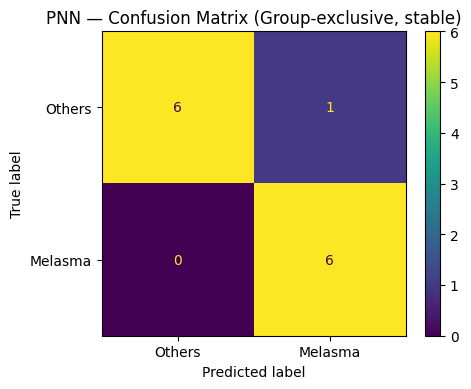

ROC-AUC: 0.9285714285714286


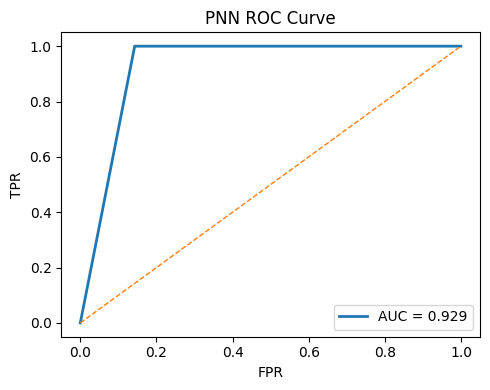

In [ ]:
y_pred = best_pnn.predict(X_te)
# class index (1 = Melasma)
cls_index = list(best_pnn.named_steps['pnn'].classes_).index(1)
y_prob = best_pnn.predict_proba(X_te)[:, cls_index]

print(classification_report(y_te, y_pred, target_names=["Others","Melasma"]))

cm = confusion_matrix(y_te, y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(cm, display_labels=["Others","Melasma"]).plot(ax=ax)
plt.title("PNN — Confusion Matrix (Group-exclusive, stable)"); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_te, y_prob)
print("ROC-AUC:", auc(fpr, tpr))
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("PNN ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()


Melasma samples:


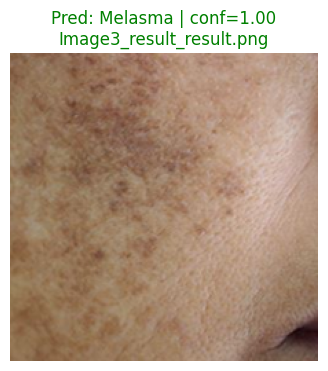

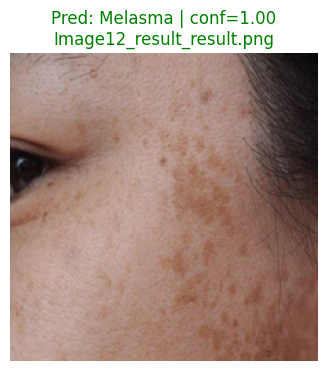

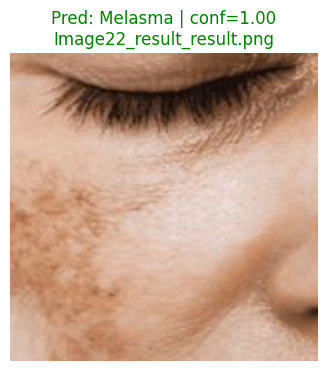

Others samples:


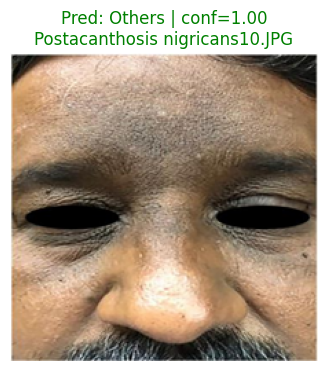

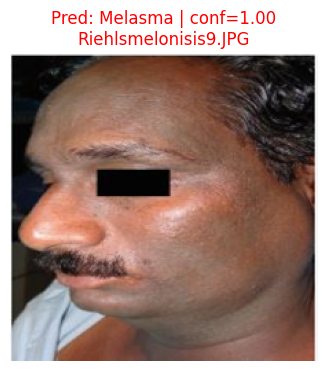

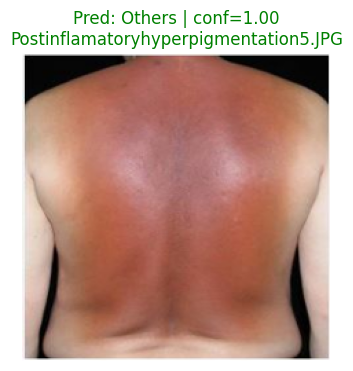

In [ ]:
def predict_one_img_path(path, feature_fn, clf):
    img = Image.open(path).convert('RGB').resize((224,224))
    arr = np.array(img, dtype=np.float32)[None, ...]
    arr = preprocess_input(arr)
    feat = vgg.predict(arr, verbose=0)
    prob1 = clf.predict_proba(feat)[0, list(clf.classes_).index(1)]
    pred  = int(prob1 >= 0.5)
    return pred, prob1, img

def show_preds(paths, true_label=None, k=4):
    picks = paths if len(paths) <= k else random.sample(paths, k)
    for p in picks:
        pred, prob1, img = predict_one_img_path(p, vgg16_features, best_pnn)
        label = "Melasma" if pred==1 else "Others"
        conf  = prob1 if pred==1 else (1.0 - prob1)
        plt.figure(figsize=(4,4))
        plt.imshow(img); plt.axis('off')
        color = "black" if true_label is None else ("green" if pred==true_label else "red")
        plt.title(f"Pred: {label} | conf={conf:.2f}\n{os.path.basename(p)}", color=color)
        plt.show()

print("Melasma samples:"); show_preds(melasma_paths, true_label=1, k=3)
print("Others samples:");  show_preds(others_paths,  true_label=0, k=3)
